# Lab1 - AI - Comparing training from scratch vs transfer learning on Kaggle datasets

**AL5.A.01 - BUT3 - IUT Vannes**


## Introduction

**Setting up the environment**


In [ ]:
# Import required packages from Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
from PIL import Image
from tempfile import TemporaryDirectory
import copy
import torch.nn.functional as F
%pip install torch torchvision torchaudio


# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
# what is your GPU ?
!nvidia-smi


Thu Sep 19 14:01:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


##  CNNs  - training from scratch

Now let's build CNN models to work on the landuse dataset

Try to reach the best performance on validation by designing other CNNs.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "validation": transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

# drive_data_dir = "/content/drive/MyDrive/data_landuse"
# local_data_dir = "/content/data_landuse"
# shutil.copytree(drive_data_dir, local_data_dir)
# data_dir = local_data_dir

# The content has to be zipped and imported in the google drive's root directory
# This ensures that we aren't bottlenecked by the I/O speed of the google drive nor the rate limits due to requesting 20k files
# Link : https://drive.google.com/file/d/1j1Qn93iJu72u6_vzvMAXTPWyzgpK21L7/view
# Copy the file to the root of your google drive
if not os.path.exists("/content/data_landuse"):
    drive_data_files = "/content/drive/MyDrive/data_landuse.zip"
    local_data_files = "/content/data_landuse.zip"
    shutil.copyfile(drive_data_files, local_data_files)
    !unzip /content/data_landuse.zip -d /content &> /dev/null
data_dir = "/content/data_landuse"

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "validation"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=2
    )
    for x in ["train", "validation"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Visualize a few images

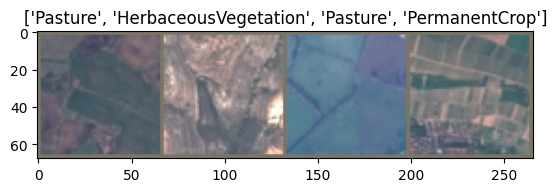

In [ ]:
# Visualize a few images


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


#Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    # Initialize lists to store loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("-" * 30)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data batches
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()  # Step the scheduler

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store losses and accuracies
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model if validation accuracy improves
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print("-" * 30)
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return model and recorded metrics
    return model, train_losses, val_losses, train_accuracies, val_accuracies


#Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#Finetuning the ConvNet


In [ ]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
class_names = image_datasets["train"].classes
num_classes = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


#Train and evaluate

------------------------------
Epoch 1/20
------------------------------
Train Loss: 1.0954 Acc: 0.6638
Validation Loss: 0.4423 Acc: 0.8595

------------------------------
Epoch 2/20
------------------------------
Train Loss: 0.6065 Acc: 0.8082
Validation Loss: 0.3638 Acc: 0.8885

------------------------------
Epoch 3/20
------------------------------
Train Loss: 0.4682 Acc: 0.8514
Validation Loss: 0.3971 Acc: 0.8690

------------------------------
Epoch 4/20
------------------------------
Train Loss: 0.3829 Acc: 0.8800
Validation Loss: 0.3549 Acc: 0.8980

------------------------------
Epoch 5/20
------------------------------
Train Loss: 0.3360 Acc: 0.8947
Validation Loss: 0.3107 Acc: 0.9123

------------------------------
Epoch 6/20
------------------------------
Train Loss: 0.3002 Acc: 0.9047
Validation Loss: 0.2634 Acc: 0.9110

------------------------------
Epoch 7/20
------------------------------
Train Loss: 0.2603 Acc: 0.9160
Validation Loss: 0.2406 Acc: 0.9165

-------------

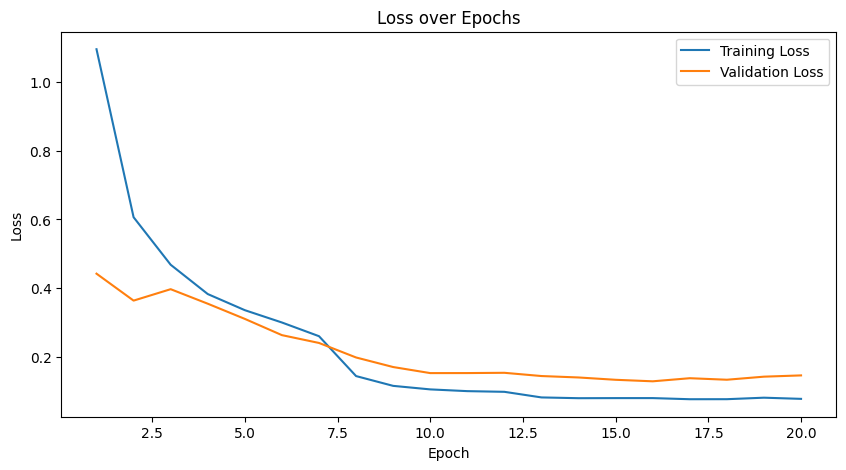

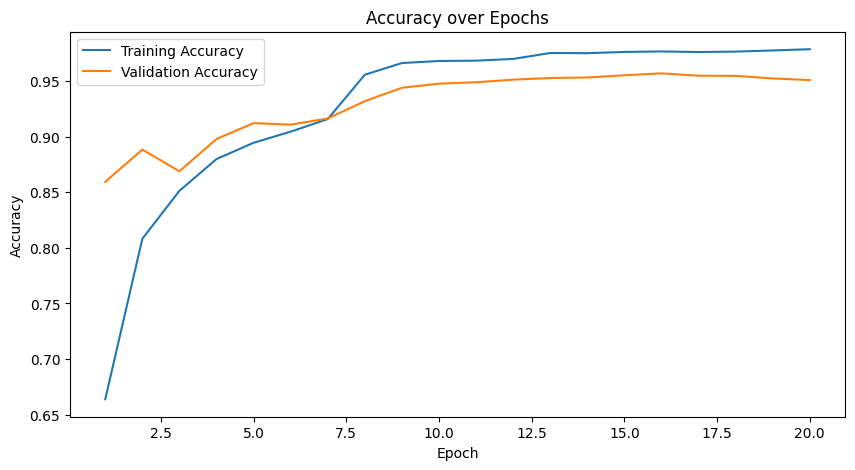

In [ ]:
# Train the model and get the recorded metrics
num_epochs = 20
model_ft, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs
)

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


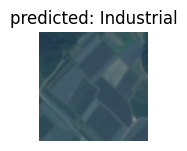

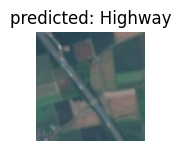

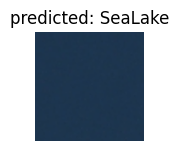

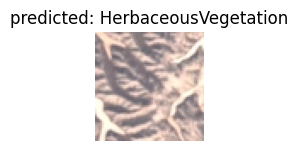

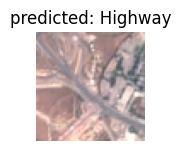

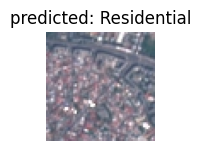

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create the model instance
num_classes = len(class_names)
cnn_scratch = CustomCNN(num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_scratch.parameters(), lr=0.003)

# Training the custom CNN
epochs = 20
train_losses_scratch, val_losses_scratch = [], []
train_acc_scratch, val_acc_scratch = [], []

for epoch in range(epochs):
    cnn_scratch.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in dataloaders["train"]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_scratch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes["train"]
    epoch_acc = running_corrects.double() / dataset_sizes["train"]
    train_losses_scratch.append(epoch_loss)
    train_acc_scratch.append(epoch_acc.item())

    print(
        f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}"
    )


Epoch [1/20] Train Loss: 1.4333 Acc: 0.4682
Epoch [2/20] Train Loss: 0.9205 Acc: 0.6626
Epoch [3/20] Train Loss: 0.7528 Acc: 0.7267
Epoch [4/20] Train Loss: 0.6495 Acc: 0.7670
Epoch [5/20] Train Loss: 0.5659 Acc: 0.7971
Epoch [6/20] Train Loss: 0.5093 Acc: 0.8153
Epoch [7/20] Train Loss: 0.4507 Acc: 0.8407
Epoch [8/20] Train Loss: 0.4036 Acc: 0.8570
Epoch [9/20] Train Loss: 0.3590 Acc: 0.8733
Epoch [10/20] Train Loss: 0.3114 Acc: 0.8928
Epoch [11/20] Train Loss: 0.2797 Acc: 0.9008
Epoch [12/20] Train Loss: 0.2573 Acc: 0.9096
Epoch [13/20] Train Loss: 0.2251 Acc: 0.9231
Epoch [14/20] Train Loss: 0.1880 Acc: 0.9354
Epoch [15/20] Train Loss: 0.1656 Acc: 0.9423
Epoch [16/20] Train Loss: 0.1357 Acc: 0.9540
Epoch [17/20] Train Loss: 0.1270 Acc: 0.9567
Epoch [18/20] Train Loss: 0.1052 Acc: 0.9650
Epoch [19/20] Train Loss: 0.0968 Acc: 0.9673
Epoch [20/20] Train Loss: 0.0857 Acc: 0.9726


## Transfer learning with pre-trained networks

**Transfer learning with Resnet18 - feature extraction technique**

In [ ]:
# Load pre-trained ResNet18 model
resnet_finetune = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = resnet_finetune.fc.in_features
resnet_finetune.fc = nn.Linear(num_ftrs, num_classes)  # Update for new dataset classes
resnet_finetune = resnet_finetune.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(resnet_finetune.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training the ResNet18
train_losses_ft, val_losses_ft = [], []
train_acc_ft, val_acc_ft = [], []

for epoch in range(epochs):
    resnet_finetune.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in dataloaders["train"]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = resnet_finetune(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes["train"]
    epoch_acc = running_corrects.double() / dataset_sizes["train"]
    train_losses_ft.append(epoch_loss)
    train_acc_ft.append(epoch_acc.item())

    print(
        f"Epoch [{epoch+1}/{epochs}] Transfer Learning - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}"
    )


Epoch [1/20] Transfer Learning - Train Loss: 1.0890 Acc: 0.6659
Epoch [2/20] Transfer Learning - Train Loss: 0.5933 Acc: 0.8131
Epoch [3/20] Transfer Learning - Train Loss: 0.4738 Acc: 0.8515
Epoch [4/20] Transfer Learning - Train Loss: 0.3762 Acc: 0.8788
Epoch [5/20] Transfer Learning - Train Loss: 0.3405 Acc: 0.8916
Epoch [6/20] Transfer Learning - Train Loss: 0.2845 Acc: 0.9085
Epoch [7/20] Transfer Learning - Train Loss: 0.2604 Acc: 0.9180
Epoch [8/20] Transfer Learning - Train Loss: 0.2334 Acc: 0.9267
Epoch [9/20] Transfer Learning - Train Loss: 0.2024 Acc: 0.9334
Epoch [10/20] Transfer Learning - Train Loss: 0.2062 Acc: 0.9342
Epoch [11/20] Transfer Learning - Train Loss: 0.1800 Acc: 0.9456
Epoch [12/20] Transfer Learning - Train Loss: 0.1708 Acc: 0.9469
Epoch [13/20] Transfer Learning - Train Loss: 0.1528 Acc: 0.9539
Epoch [14/20] Transfer Learning - Train Loss: 0.1240 Acc: 0.9624
Epoch [15/20] Transfer Learning - Train Loss: 0.1265 Acc: 0.9581
Epoch [16/20] Transfer Learning - 

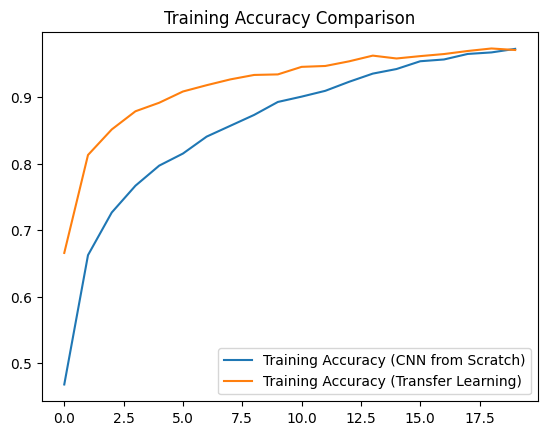

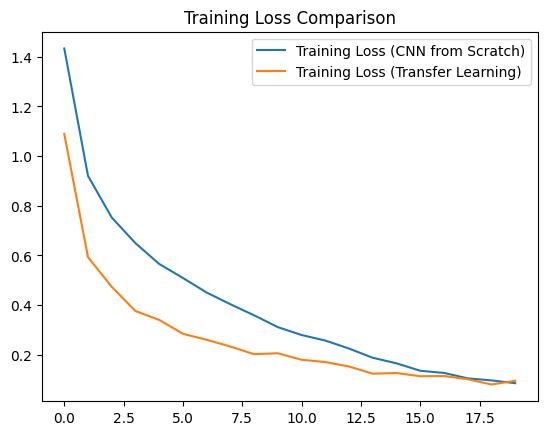

In [ ]:
# Plot the accuracy curves
plt.plot(train_acc_scratch, label="Training Accuracy (CNN from Scratch)")
plt.plot(train_acc_ft, label="Training Accuracy (Transfer Learning)")
plt.legend()
plt.title("Training Accuracy Comparison")
plt.show()

# Plot the loss curves
plt.plot(train_losses_scratch, label="Training Loss (CNN from Scratch)")
plt.plot(train_losses_ft, label="Training Loss (Transfer Learning)")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()
